In [18]:
import torch 
import torchvision
from torch.utils.data import DataLoader, Dataset
import os 
import sys
project_root = os.path.abspath("..")  # Adjust if needed

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.mnist_vae import mnist_vae
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def ELBO(x, x_hat,x_mu, x_logvar):

    rec_loss =  torch.nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KL_loss = -0.5 * torch.sum(1 + x_logvar - x_mu.pow(2) - x_logvar.exp())

    return (rec_loss + KL_loss) / x.size(0) 

In [6]:
latent_dim = 2
epochs = 100
lr = 0.001
batch_size = 128
x_dim = 28*28
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = torchvision.transforms.ToTensor()

train_data = torchvision.datasets.MNIST('./datasets/', train=True, transform=transform,
                                        target_transform=None, download=True)
test_data = torchvision.datasets.MNIST('./datasets/', train=False, transform=transform,
                                       target_transform=None, download=True)


sample_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

model = mnist_vae(latent_dim, device).to(device)
model_optim = torch.optim.Adam(params=model.parameters(), lr=lr)

In [7]:
model.train()
train_loss = []

for epoch in range(epochs):
        batch_losses = []
        for batch_i, batch in enumerate(sample_dataloader):
                # forward pass
                x = batch[0].view(-1, x_dim).to(device)
                rep_z, x_mu, x_logvar, x_rec = model(x)
                loss = ELBO(x, x_rec,x_mu, x_logvar)
                batch_losses.append(loss.data.cpu().item())
                
                model_optim.zero_grad()
                loss.backward()
                model_optim.step()
        train_loss.append(sum(batch_losses)/len(batch_losses))
        print(f"Epoch {epoch} Loss: {train_loss[-1]}")


                

Epoch 0 Loss: 195.35596025907077
Epoch 1 Loss: 170.17388981224124
Epoch 2 Loss: 165.14232296413846
Epoch 3 Loss: 162.81779091989893
Epoch 4 Loss: 161.20695694491394
Epoch 5 Loss: 159.90031348334418
Epoch 6 Loss: 158.74907677805322
Epoch 7 Loss: 157.79900637243549
Epoch 8 Loss: 156.87506057869675
Epoch 9 Loss: 156.06835050664395
Epoch 10 Loss: 155.3909366966313
Epoch 11 Loss: 154.77380543896277
Epoch 12 Loss: 154.2171260801136
Epoch 13 Loss: 153.70531564696222
Epoch 14 Loss: 153.25338295178537
Epoch 15 Loss: 152.81554882343
Epoch 16 Loss: 152.4482182559804
Epoch 17 Loss: 152.09717722835703
Epoch 18 Loss: 151.75395505856244
Epoch 19 Loss: 151.424136137351
Epoch 20 Loss: 151.14924210768478
Epoch 21 Loss: 150.89234246148004
Epoch 22 Loss: 150.5997209141397
Epoch 23 Loss: 150.39594219892453
Epoch 24 Loss: 150.168156843919
Epoch 25 Loss: 149.91032706366644
Epoch 26 Loss: 149.67497419699643
Epoch 27 Loss: 149.49672529432507
Epoch 28 Loss: 149.30838906051767
Epoch 29 Loss: 149.12079845330655
E

In [25]:
labels = []
latent_coord = []
model.eval()
for batch_i, batch in enumerate(sample_dataloader):
    labels.append(batch[1].to('cpu').numpy())
    x = batch[0].view(-1, x_dim).to(device)
    rep_z, x_mu, x_logvar, x_rec = model(x)
    latent_coord.append(x_mu.to('cpu').detach().numpy())
labels = np.concatenate(labels)
latent_coord = np.concatenate(latent_coord, axis = 0)
    

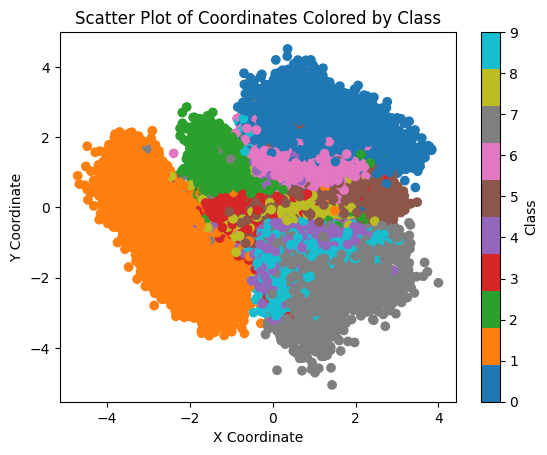

In [27]:
coordinates = latent_coord
classes = labels

# Create the scatter plot
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=classes, cmap='tab10')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Coordinates Colored by Class')

# Show the plot
plt.colorbar(label='Class')
plt.show()